# Efficiency analysis of the current setup

- catalog restart files + size + creation date
- catalog output files + date + domain
- catalog logs

## Restart files

Reading file sizes can take a long time. Thus we prep the data using a slightly more elaborate version of `du > file.txt`

In [6]:
import sys
module_path = '/home/m/m300872/warm_eurec4a/submodules/'
if not module_path in sys.path: sys.path.append(module_path)

import file_handling as fh
import datetime
import os

def du_body(target_directory, ofile, dir_only=True):
    return f'''
import subprocess

def run():
    print("this is a generated Python script skeleton")
    # Run the 'du' command and save the output to a file
    with open("{ofile}", "w") as file:
        subprocess.run(["du",{'' if dir_only else ' "-a", '} "{target_directory}"], stdout=file)

if __name__ == "__main__":
    run()
'''

header = fh.slurm_header(
    minutes=4*60,
    partition='shared',
    account='bm1183',
    email='hernan.campos@mpimet.mpg.de',
    return_string=True)

target_directory = '/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic_05'
ofile = os.path.join(os.getcwd(), 'data', f"du_mfr_{datetime.datetime.now().strftime('%Y%m%d')}.txt")

script = header+du_body(target_directory, ofile, dir_only=False)
print(script)

#!/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/bin/python3
#SBATCH --partition=shared
#SBATCH --account=bm1183
#SBATCH --nodes=1
#SBATCH --time=04:00:00
#SBATCH --mail-type=fail
#SBATCH --mail-user=hernan.campos@mpimet.mpg.de
#SBATCH --output=%j_%x.log

import builtins
def print(*args, **kwargs):
	''' for printing into SLURM logs'''
	builtins.print(*args, **kwargs, flush=True)

# THIS SCRIPT WAS AUTOMATICALLY GENERATED


import subprocess

def run():
    print("this is a generated Python script skeleton")
    # Run the 'du' command and save the output to a file
    with open("/home/m/m300872/warm_eurec4a/03_adiabatic_warming/data/du_mfr_20241204.txt", "w") as file:
        subprocess.run(["du", "-a",  "/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic_05"], stdout=file)

if __name__ == "__main__":
    run()



In [7]:
if not os.path.exists(ofile): fh.launch_slurm_script(header+du_body(target_directory, ofile))

In [8]:
import os
import pandas as pd
import time

filename = ofile
dirname = os.path.dirname(filename)

restart_files = list()
with open(filename, 'r') as f:
    for line in f.read().split('\n'):
        try:
            line = line.split('\t')
            size = line[0]
            filename = os.path.join(dirname, line[1])
            date = pd.to_datetime(line[1][-20:-5])
            mtime = pd.to_datetime(time.ctime(os.path.getmtime(filename)))
            entry = {'size':size, 'filename':filename, 'simtime':date, 'acctime':mtime}
            if not pd.isnull(date):
                restart_files.append(entry)
        except: pass

restart_files = sorted(restart_files, key=lambda x: x['simtime'])
files = restart_files

In [9]:
files[0]

{'size': '285338192',
 'filename': '/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic_05/multifile_restart_atm_20200109T133000Z.mfr',
 'simtime': Timestamp('2020-01-09 13:30:00'),
 'acctime': Timestamp('2023-12-12 16:29:13')}

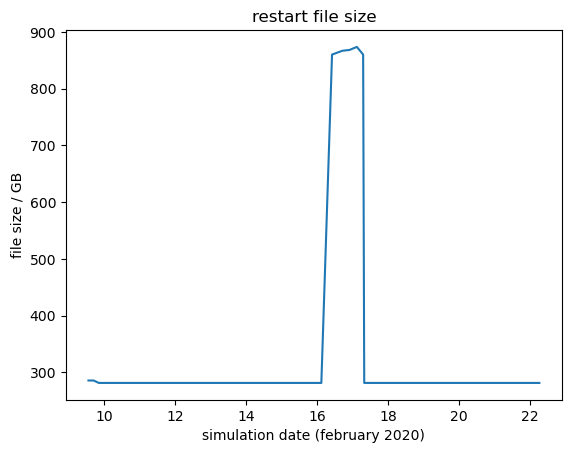

In [10]:
import matplotlib.pyplot as plt

x = [e['simtime'].day + (e['simtime'].hour / 24) + e['simtime'].minute / (24*60) for e in files]
y = [float(e['size'])/1e6 for e in files]

fig, ax = plt.subplots()
ax.plot(x,y)
ax.set_xlabel('simulation date (february 2020)')
ax.set_ylabel('file size / GB')
ax.set_title('restart file size')
fig.show()

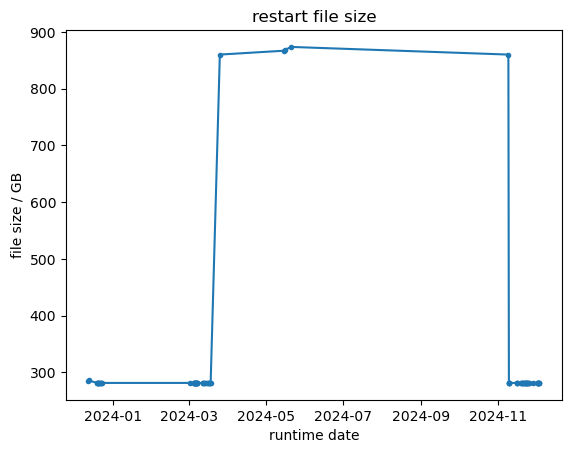

In [11]:
import matplotlib.pyplot as plt

files = sorted(files, key=lambda x: x['acctime'])
x = [e['acctime'] for e in files]
y = [float(e['size'])/1e6 for e in files]

fig, ax = plt.subplots()
ax.plot(x,y, marker='.')
ax.set_xlabel('runtime date')
ax.set_ylabel('file size / GB')
ax.set_title('restart file size')
fig.show()

## Output files

In [12]:
import os

dirname = '/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic_05'
file_list = [f for f in os.listdir(dirname) if 'surface' in f]

output_files = list()
for f in file_list:
    filename = os.path.join(dirname, f)
    dom = 2 if "DOM02" in f else 1
    date = pd.to_datetime(f[-19:-4])
    mtime = pd.to_datetime(time.ctime(os.path.getmtime(filename)))
    entry = {'filename':filename, 'dom':dom, 'simtime':date, 'acctime':mtime}
            # entry = {'size':size, 'filename':filename, 'simtime':date, 'acctime':mtime}
    if not pd.isnull(date): output_files.append(entry)

output_files = sorted(output_files, key=lambda x: x['simtime'])
files = output_files

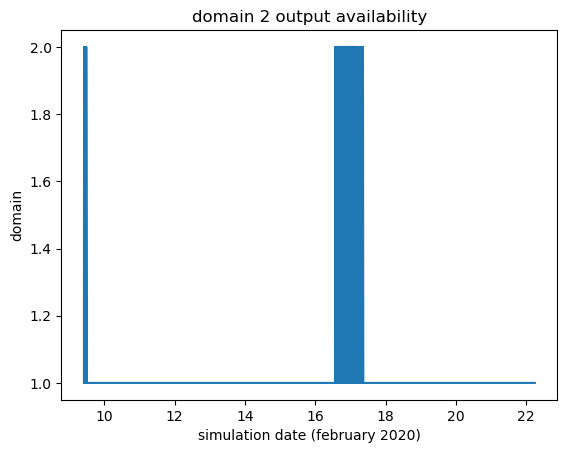

In [13]:
import matplotlib.pyplot as plt

x = [e['simtime'].day + (e['simtime'].hour / 24) + e['simtime'].minute / (24*60) for e in files]
y = [e['dom'] for e in files]

fig, ax = plt.subplots()
ax.plot(x,y)
ax.set_xlabel('simulation date (february 2020)')
ax.set_ylabel('domain')
# ax.set_xticklabels(ax.get_xticks(), rotation = 45)
ax.set_title('domain 2 output availability')
fig.show()


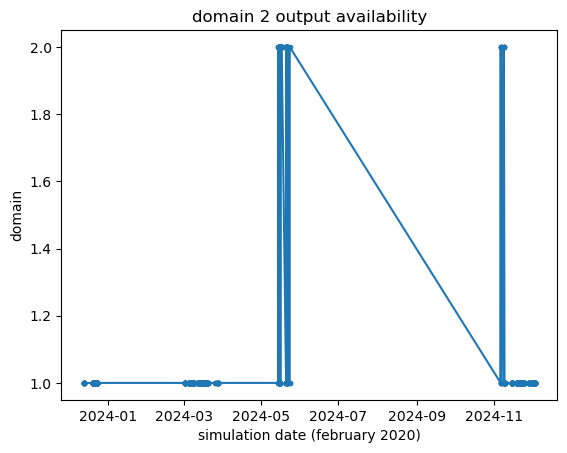

In [14]:
import matplotlib.pyplot as plt

chronological = sorted(files, key=lambda x: x['acctime'])
x = [e['acctime'] for e in chronological]
y = [e['dom'] for e in chronological]

fig, ax = plt.subplots()
ax.plot(x,y, marker='.')
ax.set_xlabel('simulation date (february 2020)')
ax.set_ylabel('domain')
ax.set_title('domain 2 output availability')
fig.show()

## Log files

In [4]:
target_directory = '/work/mh1126/m300872/eureca_icon/EUREC4A/run/logs'
ofile = os.path.join(os.getcwd(), 'data', f"du_logs_{datetime.datetime.now().strftime('%Y%m%d')}.txt")

script = header+du_body(target_directory, ofile, dir_only=False)
if not os.path.exists(ofile): fh.launch_slurm_script(script)

#!/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/bin/python3
#SBATCH --partition=shared
#SBATCH --account=bm1183
#SBATCH --nodes=1
#SBATCH --time=04:00:00
#SBATCH --mail-type=fail
#SBATCH --mail-user=hernan.campos@mpimet.mpg.de
#SBATCH --output=%j_%x.log

import builtins
def print(*args, **kwargs):
	''' for printing into SLURM logs'''
	builtins.print(*args, **kwargs, flush=True)

# THIS SCRIPT WAS AUTOMATICALLY GENERATED


import subprocess

def run():
    print("this is a generated Python script skeleton")
    # Run the 'du' command and save the output to a file
    with open("/home/m/m300872/warm_eurec4a/03_adiabatic_warming/data/du_logs_20241204.txt", "w") as file:
        subprocess.run(["du", "-a",  "/work/mh1126/m300872/eureca_icon/EUREC4A/run/logs"], stdout=file)

if __name__ == "__main__":
    run()



In [10]:
def find_matching_lines(file_path, keyword):
    """
    Search for lines in a text file that contain a specified keyword.

    Args:
        file_path (str): The path to the text file to be searched.
        keyword (str): The keyword to search for within the lines of the file.

    Returns:
        list: A list of lines from the file that contain the specified keyword.
        
    Raises:
        FileNotFoundError: If the specified file cannot be found.
        IOError: If there is an issue reading the file.
    """
    try:
        matching_lines = []
        with open(file_path, 'r') as file:
            for line in file:
                if keyword in line:
                    matching_lines.append(line.strip())  # .strip() to remove newline characters
        return matching_lines
    except FileNotFoundError: raise FileNotFoundError(f"The file '{file_path}' was not found.")
    except IOError:           raise IOError(f"An error occurred while reading the file '{file_path}'.")

def has_line(filename, line):
    return len(find_matching_lines(filename, line)) > 0
    
def get_timestamp(string):
    for word in string.split(' '): 
        try:    timestamp = pd.to_datetime(word)
        except: pass
    return timestamp

def get_nodes(filename):
    return int(find_matching_lines(filename, '#SBATCH --nodes=')[0].split('=')[-1])

def get_walltime(filename):
    try: # if the run went through, we read the slurm report at the end
        lines = find_matching_lines(filename, 'Elapsed time')
        lines = lines[0].split(' ')
        for word in lines:
            try:
                d = pd.Timedelta(word)
                if type(d) == type(pd.Timedelta('01h01m01s')): return pd.Timedelta(word).total_seconds() / (60*60)
            except: pass
    except: # if a restart is launched there is no slurm timer report at the end of the log
        lines = find_matching_lines(filename, 'total')[-2].split(' ')
        for word in lines:
            if word.endswith('m'):
                try:
                    d = pd.Timedelta(word)
                    if type(d) == type(pd.Timedelta('01h01m01s')): 
                        return pd.Timedelta(word).total_seconds() / (60*60)
                except: pass 
            
def get_end_date(filename):
    line = find_matching_lines(filename, 'model time:')[-1]
    line = line.split('model time:')[-1]
    line = line.split('forecast time')[0]
    try:    date = pd.to_datetime(line)
    except: date = None
    return date

def get_start_date(filename):
    return get_timestamp(find_matching_lines(filename, 'Start date')[-1])

def get_start_date(filename):
    line = find_matching_lines(filename, 'model time:')[0]
    line = line.split('model time:')[-1]
    line = line.split('forecast time')[0]
    try:    date = pd.to_datetime(line)
    except: date = None
    return date

def get_simulated_time(filename):
    try:    result = (get_end_date(filename) -  get_start_date(filename)).total_seconds() / (60*60)
    except: result = None
    return result

logfile = '/work/mh0010/m300408/DVC-test/EUREC4A-ICON/EUREC4A/run/logs/LOG.exp.DOM01+DOM02.run.562478.o'
print(f'walltime:       {get_walltime(logfile):4.3f} ')
print(f'nodes:          {get_nodes(logfile):4.3f} ')
print(f'simulated time: {get_simulated_time(logfile):4.3f} ')
print()
print('simulated seconds per node hour used:', (get_simulated_time(logfile)*60*60)/(get_nodes(logfile) * get_walltime(logfile)) )

walltime:       4.917 
nodes:          500.000 
simulated time: 19.998 

simulated seconds per node hour used: 29.285694915254236


In [15]:

def du_body_walltime(ifile, ofile):
    return f'''
import os
import pandas as pd
import time

def find_matching_lines(file_path, keyword):
    """
    Search for lines in a text file that contain a specified keyword.

    Args:
        file_path (str): The path to the text file to be searched.
        keyword (str): The keyword to search for within the lines of the file.

    Returns:
        list: A list of lines from the file that contain the specified keyword.
        
    Raises:
        FileNotFoundError: If the specified file cannot be found.
        IOError: If there is an issue reading the file.
    """
    try:
        matching_lines = []
        # with open(file_path, 'r') as file:
        with open(file_path, 'r', encoding='utf-8', errors='replace') as file:
            for line in file:
                if keyword in line:
                    matching_lines.append(line.strip())  # .strip() to remove newline characters
        return matching_lines
    except FileNotFoundError: raise FileNotFoundError(f"The file '{{file_path}}' was not found.")
    except IOError:           raise IOError(f"An error occurred while reading the file '{{file_path}}'.")

def has_line(filename, line):
    return len(find_matching_lines(filename, line)) > 0
    
def get_timestamp(string):
    for word in string.split(' '): 
        try:    timestamp = pd.to_datetime(word)
        except: pass
    return timestamp

def get_nodes(filename):
    return int(find_matching_lines(filename, '#SBATCH --nodes=')[0].split('=')[-1])

def get_walltime(filename):
    try: # if the run went through, we read the slurm report at the end
        lines = find_matching_lines(filename, 'Elapsed time')
        lines = lines[0].split(' ')
        for word in lines:
            try:
                d = pd.Timedelta(word)
                if type(d) == type(pd.Timedelta('01h01m01s')): return pd.Timedelta(word).total_seconds() / (60*60)
            except: pass
    except: # if a restart is launched there is no slurm timer report at the end of the log
        lines = find_matching_lines(filename, 'total')[-2].split(' ')
        for word in lines:
            if word.endswith('m'):
                try:
                    d = pd.Timedelta(word)
                    if type(d) == type(pd.Timedelta('01h01m01s')): 
                        return pd.Timedelta(word).total_seconds() / (60*60)
                except: pass 
            
def get_end_date(filename):
    line = find_matching_lines(filename, 'model time:')[-1]
    line = line.split('model time:')[-1]
    line = line.split('forecast time')[0]
    try:    date = pd.to_datetime(line)
    except: date = None
    return date

def get_start_date(filename):
    return get_timestamp(find_matching_lines(filename, 'Start date')[-1])

def get_start_date(filename):
    line = find_matching_lines(filename, 'model time:')[0]
    line = line.split('model time:')[-1]
    line = line.split('forecast time')[0]
    try:    date = pd.to_datetime(line)
    except: date = None
    return date

def get_simulated_time(filename):
    try:    result = (get_end_date(filename) -  get_start_date(filename)).total_seconds() / (60*60)
    except: result = None
    return result
    
ifile = "{ifile}"
ofile = "{ofile}"

verbose = True

log_files = list()
with open(ifile, 'r') as f:
    for line in f.read().split('\\n'):
        line = line.split('\\t')
        size = line[0]
        filename = line[1]
        if not filename.endswith('/logs'):
            print(filename, end=',')
            mtime = pd.to_datetime(time.ctime(os.path.getmtime(filename)))
            walltime = get_walltime(filename)
            print(walltime, end=',')
            nodes = get_nodes(filename)
            print(nodes, end=',')
            simtime = get_simulated_time(filename)
            print(simtime, end=',')
            print()
            with open(ofile, 'a') as out:
                for item in [filename, size, mtime, walltime, nodes, simtime]: 
                    out.write(str(item))
                    out.write(',')
                out.write('\\n')
'''

ifile = os.path.join(os.getcwd(), 'data', f"du_logs_{datetime.datetime.now().strftime('%Y%m%d')}.txt")
ofile = os.path.join(os.getcwd(), 'data', f"du_logs_sup2_{datetime.datetime.now().strftime('%Y%m%d')}.txt")

script = header+du_body_walltime(ifile, ofile)
if not os.path.exists(ofile): fh.launch_slurm_script(script)
# print(script)

In [49]:
import os
import pandas as pd
import time

filename = ofile
filename = '/home/m/m300872/warm_eurec4a/03_adiabatic_warming/data/du_logs_sup_20241204.txt'
dirname = os.path.dirname(filename)

log_files = list()
with open(filename, 'r') as f:
    for line in f.read().split('\n'):
        try:
            line = line.split(',')
            filename, size, mtime, walltime, nodes, simtime, _ = line
            entry = {'size':int(size), 'filename':filename, 'simtime':float(simtime), 'acctime':pd.to_datetime(mtime), 'nodes':int(nodes), 'walltime':float(walltime)}
            # if not pd.isnull(mtime):
            if not simtime == None:
                log_files.append(entry)
        except: pass

log_files = sorted(log_files, key=lambda x: x['acctime'])
files = log_files

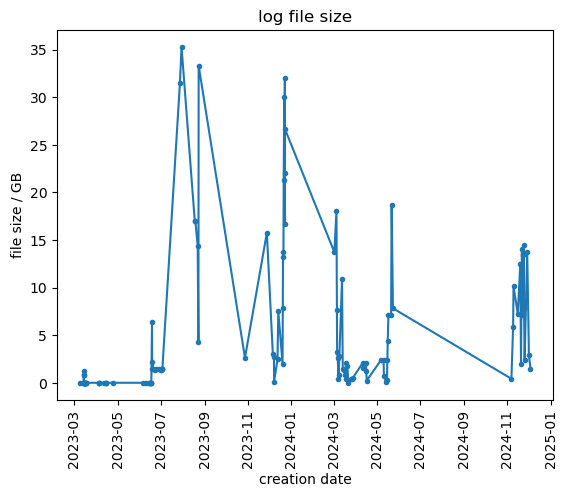

In [50]:
import matplotlib.pyplot as plt

# x = [e['simtime'].day + (e['simtime'].hour / 24) + e['simtime'].minute / (24*60) for e in files]
x = [e['acctime'] for e in files]
y = [float(e['size'])/1e6 for e in files]

fig, ax = plt.subplots()
ax.plot(x,y, marker='.')

ax.tick_params(axis='x', rotation=90)
ax.set_xlabel('creation date')
ax.set_ylabel('file size / GB')
ax.set_title('log file size')

fig.show()

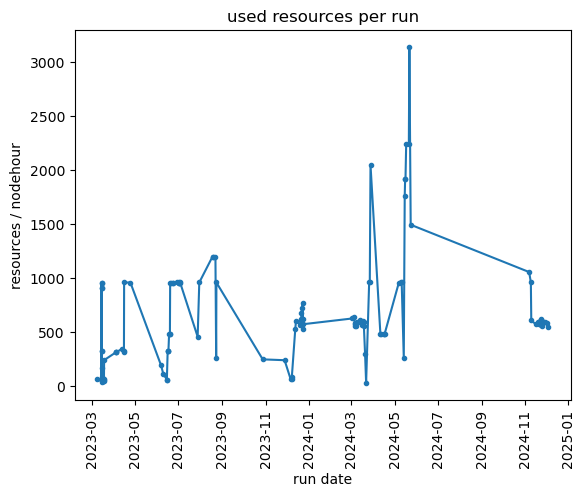

In [51]:
for entry in files:
    entry['nodehours'] = entry['nodes'] * entry['walltime']
    
x = [e['acctime']   for e in files]
y = [e['nodehours'] for e in files]

fig, ax = plt.subplots()
ax.plot(x,y, marker='.')

ax.tick_params(axis='x', rotation=90)
ax.set_xlabel('run date')
ax.set_ylabel('resources / nodehour')
ax.set_title('used resources per run')

fig.show()

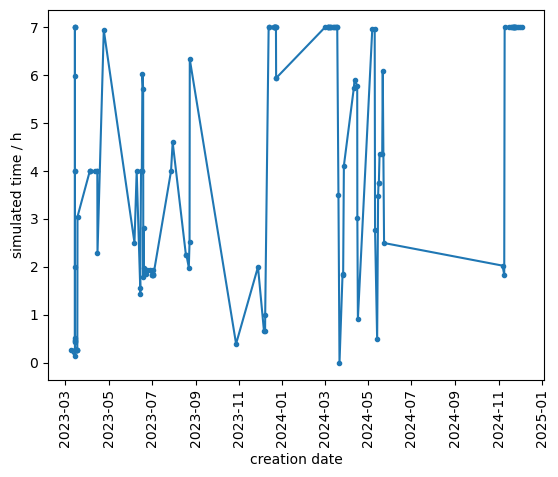

In [52]:
x = [e['acctime']   for e in files]
y = [e['simtime'] for e in files]

fig, ax = plt.subplots()
ax.plot(x,y, marker='.')

ax.tick_params(axis='x', rotation=90)
ax.set_xlabel('creation date')
ax.set_ylabel('simulated time / h')
# ax.set_title('log file size')

fig.show()

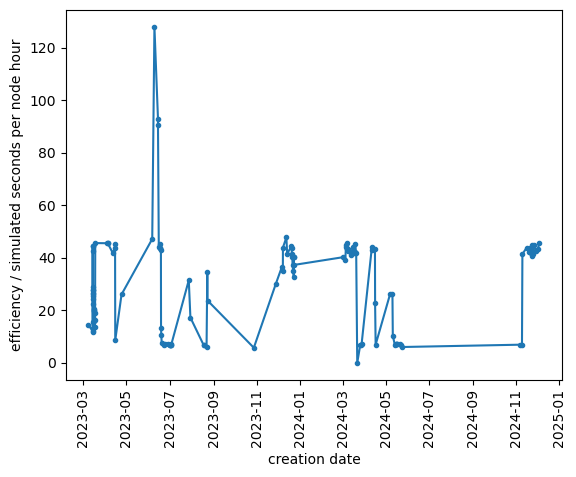

In [53]:
for entry in files:
    entry['sspnh'] = (entry['simtime'] * 3600) / entry['nodehours']
    
x = [e['acctime']   for e in files]
y = [e['sspnh'] for e in files]

fig, ax = plt.subplots()
ax.plot(x,y, marker='.')

ax.tick_params(axis='x', rotation=90)
ax.set_xlabel('creation date')
ax.set_ylabel('efficiency / simulated seconds per node hour')
# ax.set_title('log file size')

fig.show()